# Real Case: classification

In [20]:
# Connecting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Part 1. Familiarization with data, processing of omissions and outliers

### Bank customer data:

- *age* (age);
- *job* (field of employment);
- *marital* (marital status);
- *education* (level of education);
- *default* (is there an overdue loan);
- *housing* (is there a loan for housing);
- *loan* (is there a loan for personal needs);
- *balance* (balance).

### Data related to the last contact in the context of the current marketing campaign:

- *contact* (type of customer contact);
- *month* (the month in which the last contact was made);
- *day* (the day on which the last contact was made);
- *duration* (contact duration in seconds).

### Other signs:

- *campaign* (number of contacts with this client during the current campaign);
- *pdays* (the number of missed days from the last marketing campaign to the contact in the current campaign);
- *previous* (the number of contacts before the current campaign)
- *poutcome* (the result of the last marketing campaign).

The target variable *deposit*, which determines whether the client agrees to open a deposit with the bank. This is what we will try to predict in this case.

### Part 1

In [21]:
data_bank_fin = pd.read_csv('data/bank_fin.zip', sep = ';')

In [22]:
data_bank_fin.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [23]:
# We examine the data for omissions
data_bank_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [24]:
data_bank_fin.isna().sum() 

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [25]:
# We will output all the signs with a small (< 15) number of different categories (attribute values)
for column in data_bank_fin.columns:
    if pd.DataFrame(data_bank_fin[column].value_counts()).shape[0] < 15:
        print(f'Feature {column}')
        display(pd.DataFrame(data_bank_fin[column].value_counts()))

Feature job


,job
management,2566
blue-collar,1944
technician,1823
admin.,1334
services,923
retired,778
self-employed,405
student,360
unemployed,357
entrepreneur,328


Feature marital


,marital
married,6351
single,3518
divorced,1293


Feature education


,education
secondary,5476
tertiary,3689
primary,1500
unknown,497


Feature default


,default
no,10994
yes,168


Feature housing


,housing
no,5881
yes,5281


Feature loan


,loan
no,9702
yes,1460


Feature contact


,contact
cellular,8042
unknown,2346
telephone,774


Feature month


,month
may,2824
aug,1519
jul,1514
jun,1222
nov,943
apr,923
feb,776
oct,392
jan,344
sep,319


Feature poutcome


,poutcome
unknown,8326
failure,1228
success,1071
other,537


Feature deposit


,deposit
no,5873
yes,5289


In [26]:
# Convert the balance attribute so that it is correctly read as a real number (float)
data_bank_fin['balance'] = data_bank_fin['balance'].apply(lambda x: x.replace(' ','').replace('$','').replace(',','.') if type(x) == str else np.nan).astype(float)
print('The average value of the "balance" feature converted to the correct form:',round(data_bank_fin['balance'].mean(),3))

The average value of the "balance" feature converted to the correct form: 1529.129


In [27]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
data_bank_fin['balance'] = data_bank_fin['balance'].fillna((data_bank_fin['balance'].median())) # заполняем пропущенные значение медианным значением признака 
print('The number of omissions after processing the feature:',data_bank_fin['balance'].isna().sum())

The number of omissions after processing the feature: 0


In [28]:
print('The average value of the balance feature converted to the correct form:', round(data_bank_fin['balance'].mean(),3))

The average value of the balance feature converted to the correct form: 1526.936


In [29]:
# Let's process the omissions in the categorical attributes 'job' and 'education', replacing them with modal values
data_bank_fin['job'] = data_bank_fin['job'].apply(lambda job_type: data_bank_fin['job'].mode()[0] if job_type == 'unknown' else job_type)
display(data_bank_fin['job'].value_counts())
data_bank_fin['education'] = data_bank_fin['education'].apply(lambda job_type: data_bank_fin['education'].mode()[0] if job_type == 'unknown' else job_type)
data_bank_fin['education'].value_counts()
# As a result of processing, omissions were excluded from the attribute

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [30]:
# most popular job and education:
job_most_pop = (data_bank_fin['job'].value_counts().nlargest(1).index)[0]
education_most_pop = (data_bank_fin['education'].value_counts().nlargest(1).index)[0]
# Creating masks
mask_job, mask_edu = (data_bank_fin['job'] == job_most_pop),(data_bank_fin['education'] == education_most_pop)
round(data_bank_fin[mask_job & mask_edu]['balance'].mean(),3)

1598.883

(array([0]), [Text(0, 0, '')])

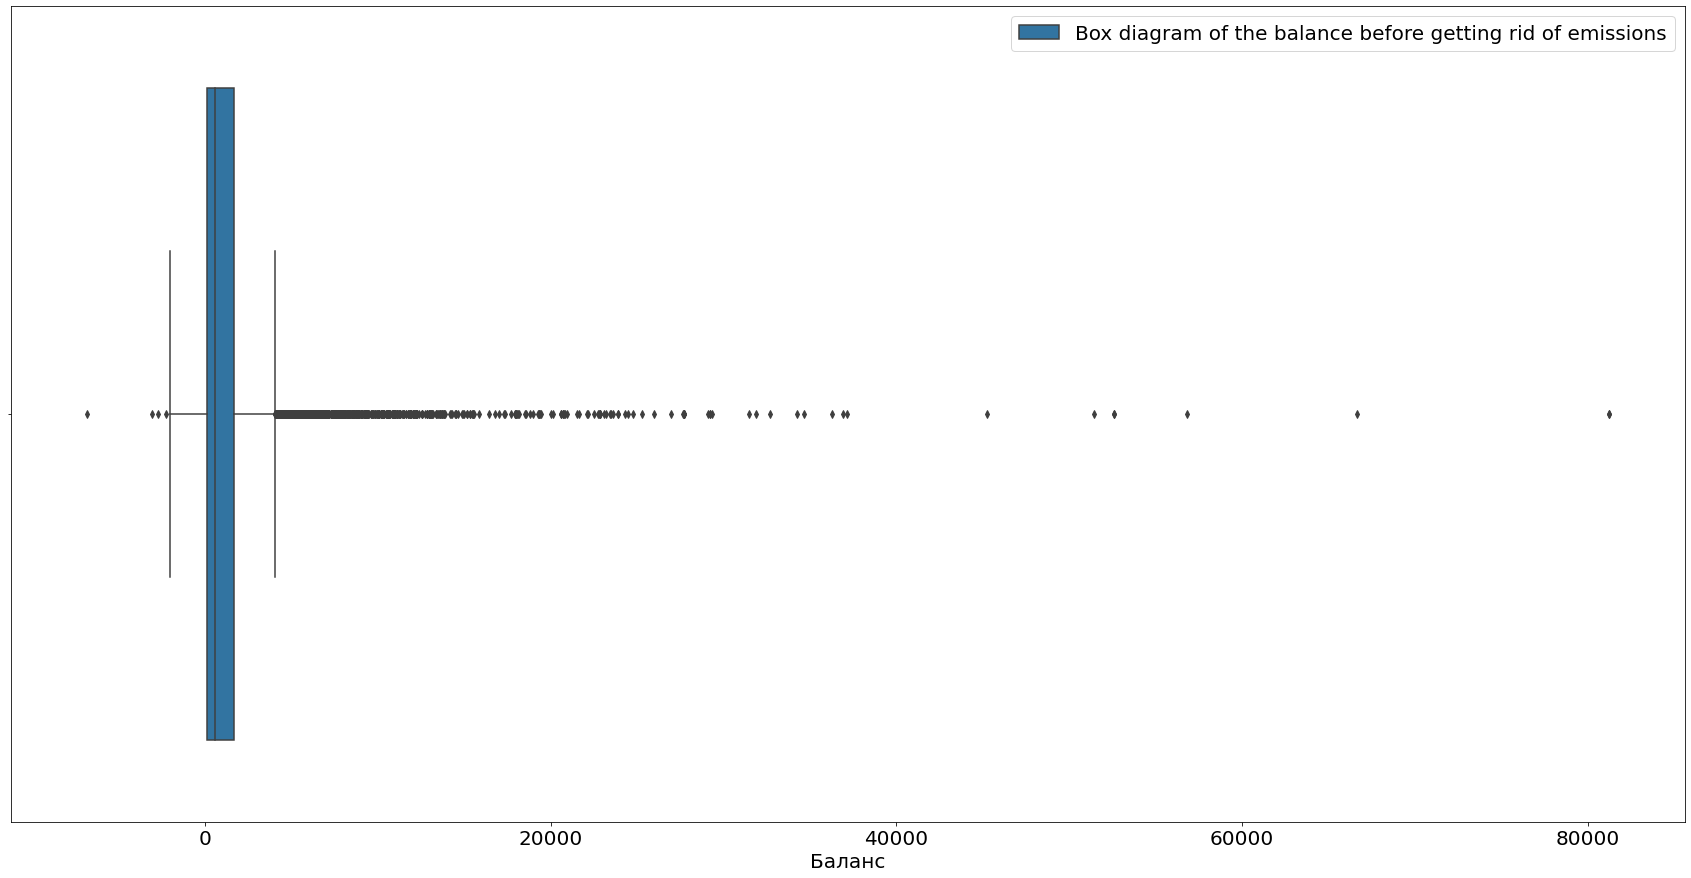

In [31]:
fig, axes = plt.subplots(1,1,figsize=(30, 15)) 

histplot = sns.boxplot(data=data_bank_fin, x="balance", ax=axes)
histplot.set_xlabel('Баланс', fontsize = 20)
histplot.set_ylabel('',fontsize = 20 )
histplot.legend(
    ['Box diagram of the balance before getting rid of emissions'],
    loc='upper right',
    fontsize=20
)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

In [32]:
# Remove all outliers for the balance feature
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound
outliers, cleaned, lower_bound, upper_bound = outliers_iqr(data_bank_fin, 'balance')
print(f'The number of emissions by the Tukey method: {outliers.shape[0]}')
print(f'The resulting number of records: {cleaned.shape[0]}')
print(f'The lower limit of the "balance" attribute: {lower_bound}')
print(f'Upper limit of the "balance" attribute: {upper_bound}')

The number of emissions by the Tukey method: 1057
The resulting number of records: 10105
The lower limit of the "balance" attribute: -2241.0
Upper limit of the "balance" attribute: 4063.0


In [33]:
data_bank_fin_cleaned = cleaned

(array([0]), [Text(0, 0, '')])

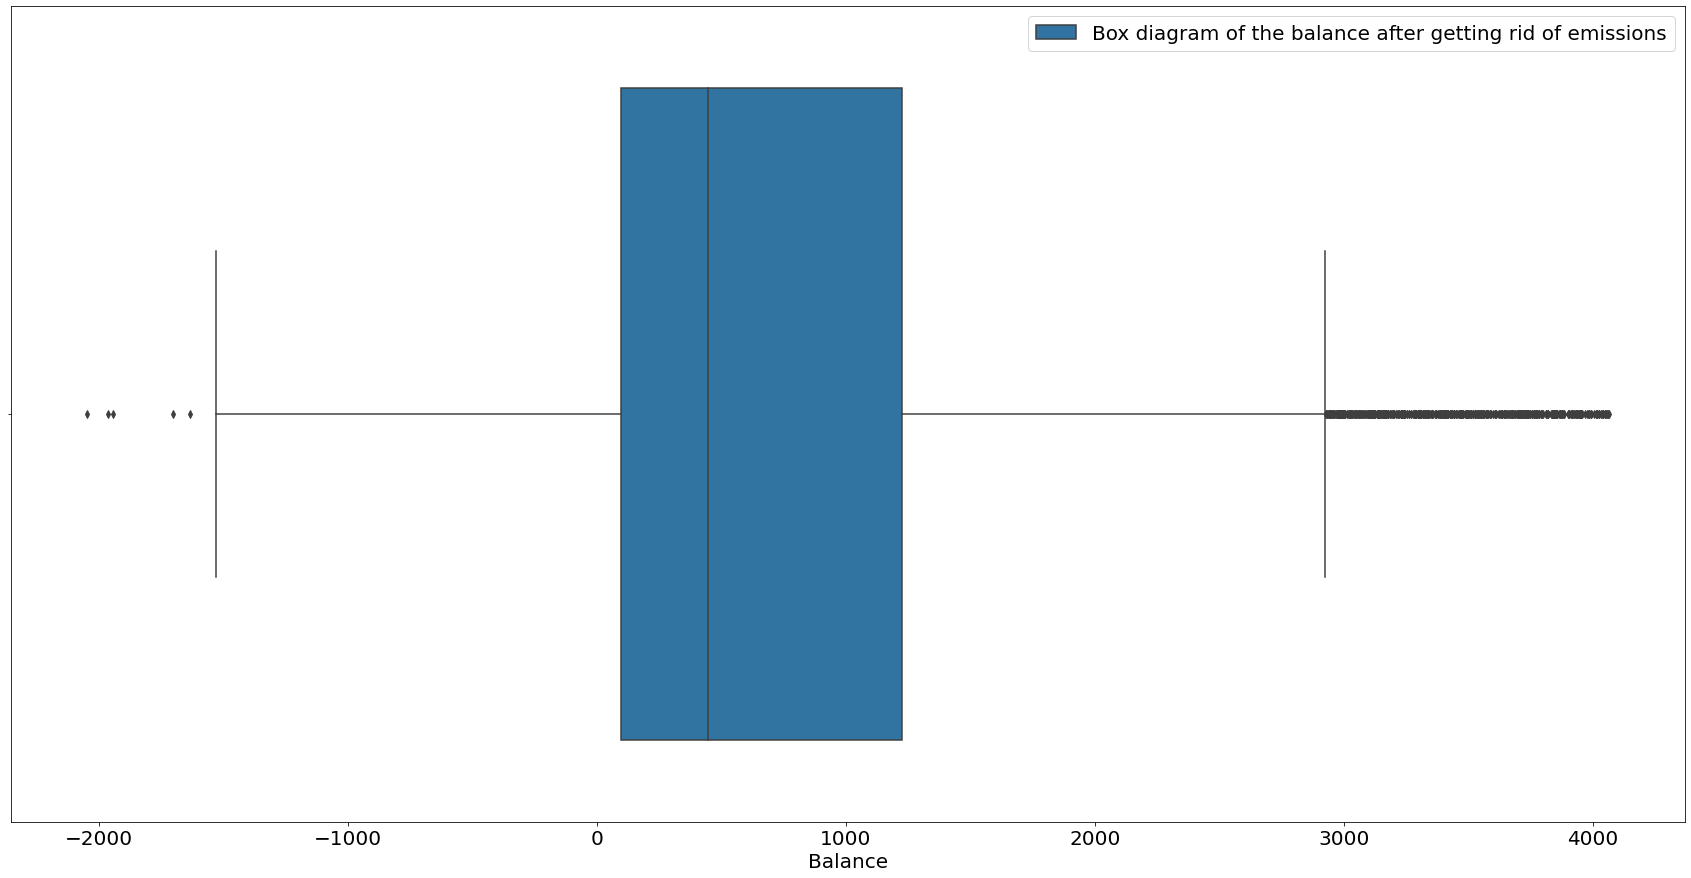

In [34]:
fig, axes = plt.subplots(1,1,figsize=(30, 15)) 

histplot = sns.boxplot(data=data_bank_fin_cleaned, x="balance", ax=axes)
histplot.set_xlabel('Balance', fontsize = 20)
histplot.set_ylabel('',fontsize = 20 )
histplot.legend(
    ['Box diagram of the balance after getting rid of emissions'],
    loc='upper right',
    fontsize=20
)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

## Part 2: EDA 

,deposit
no,5424
yes,4681


[Text(0, 0.0, '0.0'),
 Text(0, 1000.0, '1000.0'),
 Text(0, 2000.0, '2000.0'),
 Text(0, 3000.0, '3000.0'),
 Text(0, 4000.0, '4000.0'),
 Text(0, 5000.0, '5000.0'),
 Text(0, 6000.0, '6000.0')]

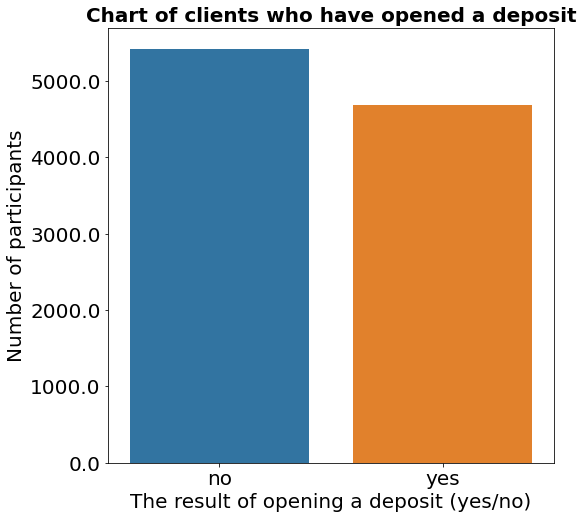

In [35]:
# Let's examine the ratio of classes in your data for unbalance, illustrate the result
data_deposit_group = data_bank_fin_cleaned['deposit'].value_counts()
display(pd.DataFrame(data_deposit_group))
data_deposit_group = pd.DataFrame(data_deposit_group)
plt.figure(figsize=(8, 8))
barplot = sns.barplot(
    data = data_deposit_group,
    x = data_deposit_group.index, 
    y = 'deposit'
    )
barplot.set_title('Chart of clients who have opened a deposit', fontweight='bold', fontsize=20)
barplot.set_xlabel("The result of opening a deposit (yes/no)", size = 20)
barplot.set_ylabel("Number of participants", size = 20)
barplot.set_xticklabels(data_deposit_group.index, size = 20, rotation=0)
barplot.set_yticklabels(barplot.get_yticks(), size = 20)

Descriptive statistics for numerical features


,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Numerical features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


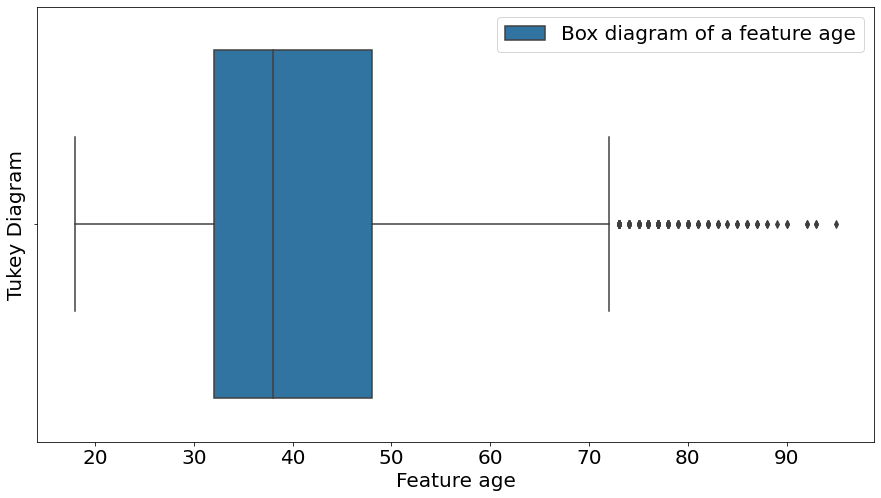

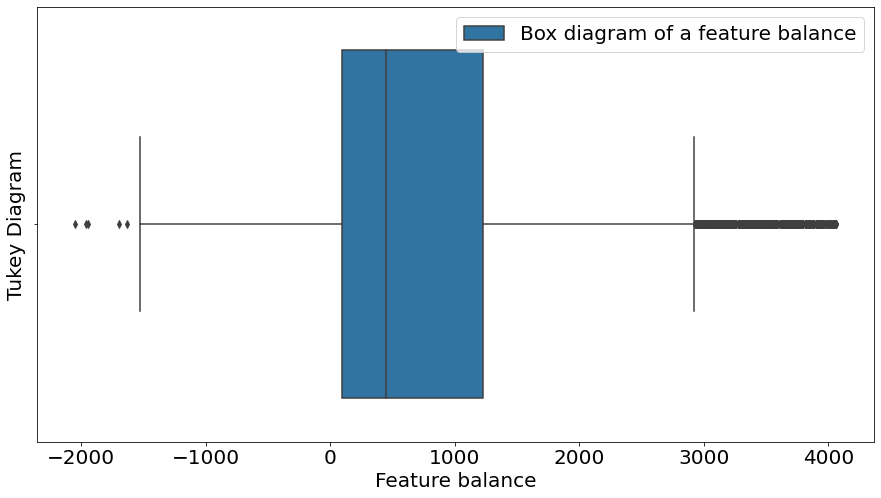

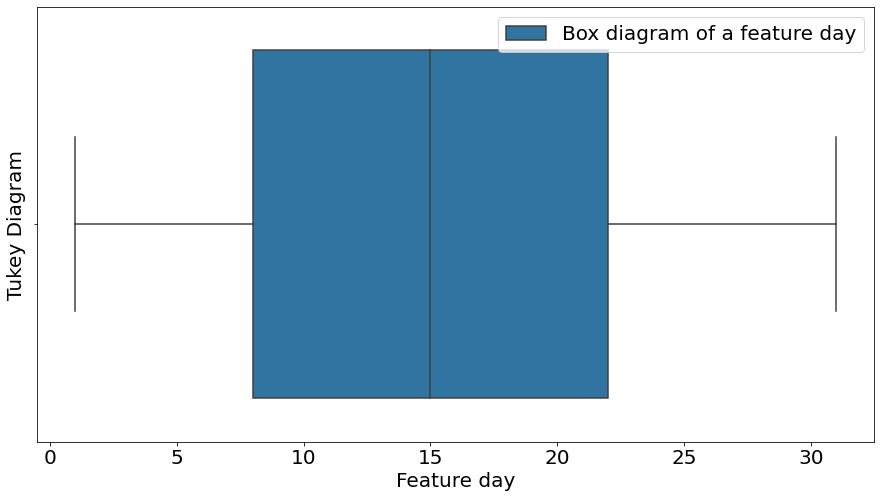

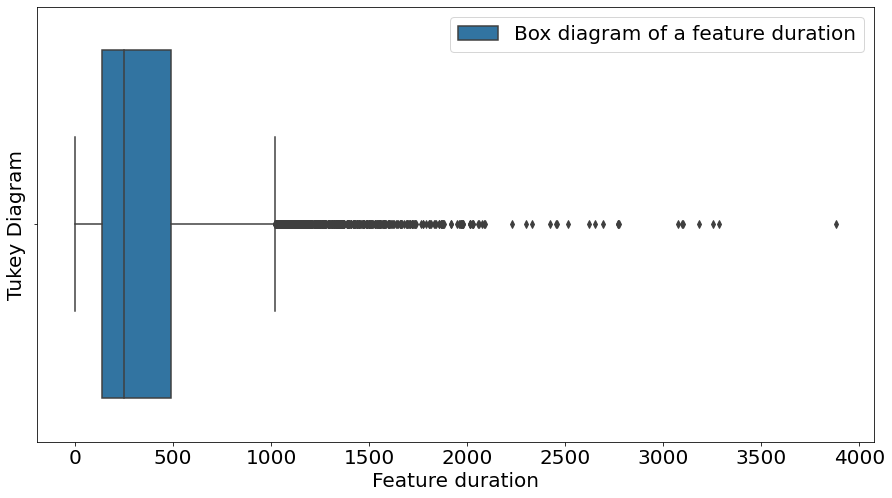

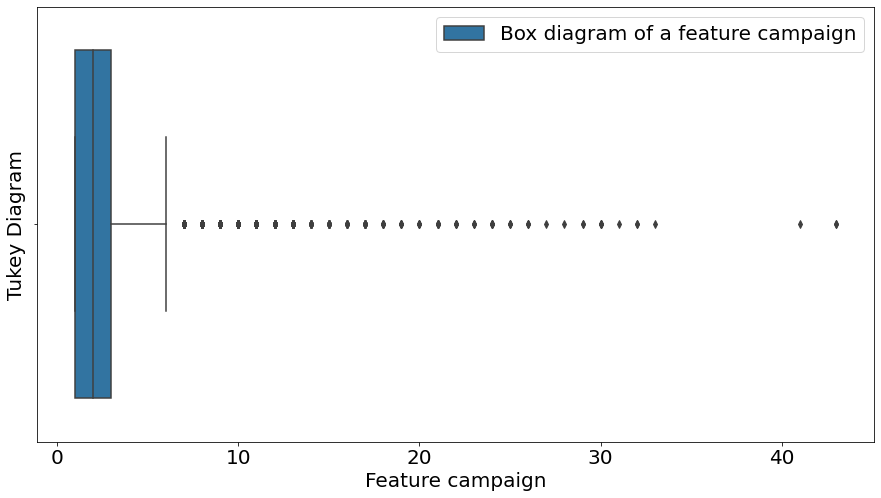

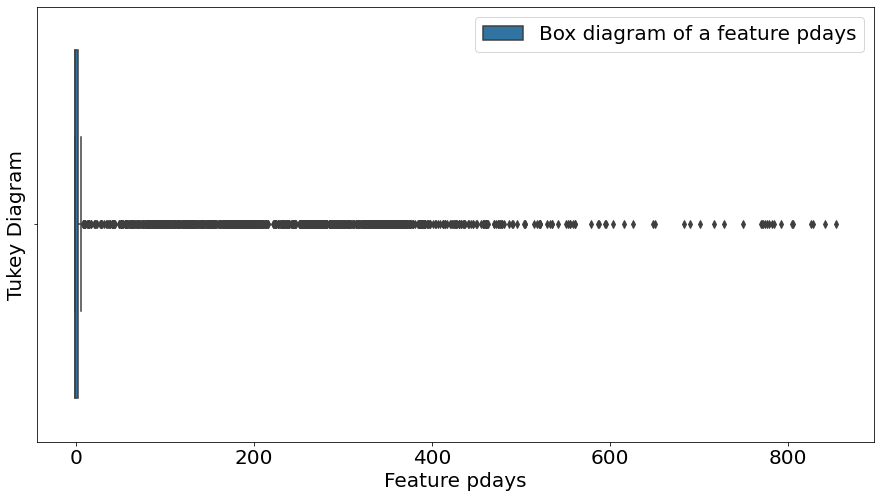

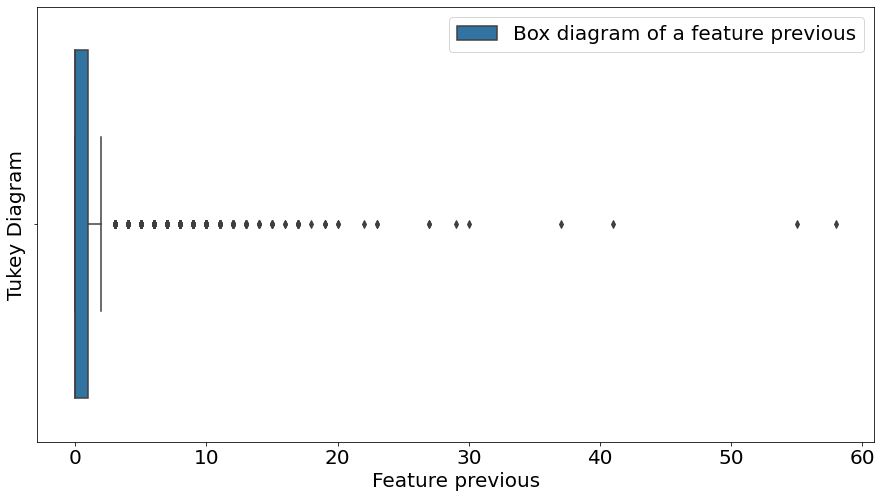

In [36]:
# We will output numeric features
print('Descriptive statistics for numerical features')
display(data_bank_fin_cleaned.describe())
print('Numerical features:', list(data_bank_fin_cleaned.describe().columns))
# Let's build boxes with moustaches for each feature
# Let's create a function for drawing boxes with moustaches
feature = 'balance'
def plot_boxplot(data_for_boxplot, feature):
    fig, axes = plt.subplots(1,1,figsize=(15, 8)) 

    histplot = sns.boxplot(data=data_for_boxplot, x=feature, ax=axes)
    histplot.set_xlabel(f'Feature {feature}', fontsize = 20)
    histplot.set_ylabel('Tukey Diagram',fontsize = 20 )
    histplot.legend(
        [f'Box diagram of a feature {feature}'],
        loc='upper right',
        fontsize=20
    )
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)

# We consistently output the Tukey diagrams for our features numericalх
for column in list(data_bank_fin_cleaned.describe().columns):
    plot_boxplot(data_bank_fin_cleaned, column)

### Intermediate conclusions 
1. The maximum age of the client reaches 95 years. It is not known how real this is
2. The pdays sign is unclear, since about 800 days - 2.5 years passed from the previous company to the contact in this company 
3. Some had about 60 contacts before the current company (previous sign)
4. Some people in the real company had about 40 contacts, it is still unclear how real this is
5. With some clients, the duration of contact was about an hour or 3600 seconds

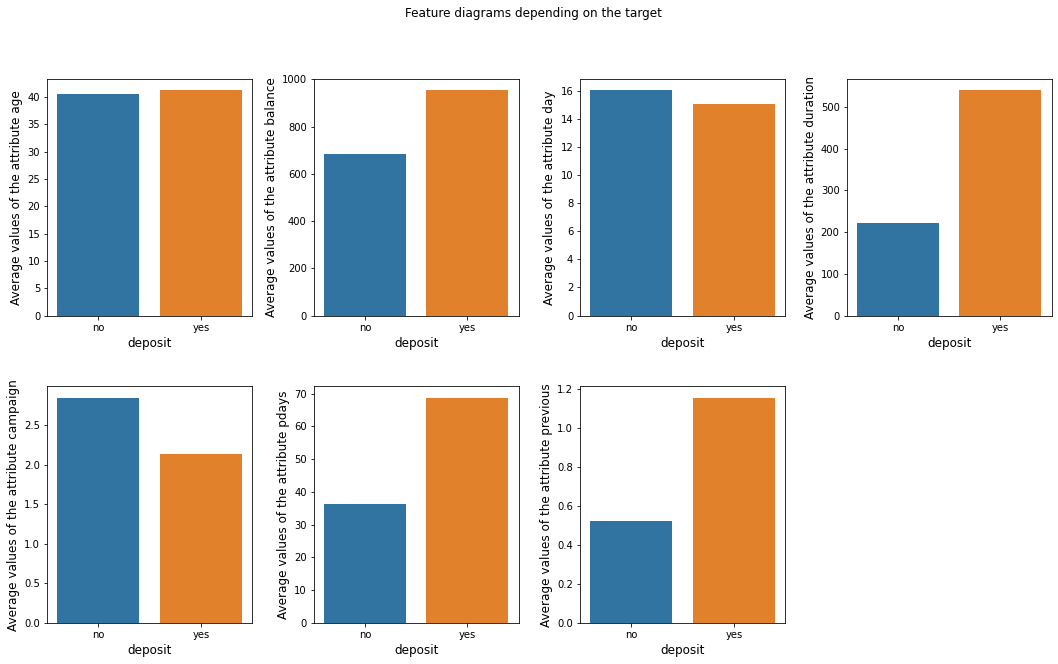

In [37]:
columns_to_barplot = (list(data_bank_fin_cleaned.describe().columns))
N_columns = len(columns_to_barplot)
n_columns_in_plot = 4
if N_columns % 2 == 1:
    n_rows_in_plot = (N_columns + 1) // n_columns_in_plot
figsize_weight = 24
figsize_height = 10
fig, axes = plt.subplots(n_rows_in_plot, n_columns_in_plot, figsize=(18, 10))
plt.subplots_adjust(hspace = 0.3, wspace=0.3)
k = -1
fig.suptitle('Feature diagrams depending on the target')

for i in range(0,n_rows_in_plot):
    for j in range(0,n_columns_in_plot):
        k += 1
        
        if k == N_columns:
            axes[i, j].remove()
            break
        column = columns_to_barplot[k]
        data_group_numbering_feature = data_bank_fin_cleaned.groupby(['deposit'])[[column]].agg(['mean','sum','min','max'])
        axes[i, j] = sns.barplot(ax=axes[i, j], data=data_group_numbering_feature, x=data_group_numbering_feature.index, y=(column,'mean'))
        axes[i, j].set_ylabel(f"Average values of the attribute {column}", size = 12)
        axes[i, j].set_xlabel(f"deposit", size = 12, rotation = 0)
        



### Intermediate conclusions
1. Among those who took a deposit, the account balance was on average about 30 higher %
2. There are no age differences (judging by the diagram) for both target values
3. The average number of contacts (previous attribute) is 50% higher for the 'yes' target value
4. The average number of days before the contact from the end of the previous company (pdays sign) for some reason for "yes" is about 50 more%
5. The total duration of contacts (duration) on average for 'yes' is 50% longer than for 'no', which is logical. Yes-clients tend to have longer discussions, so contacts are long, but their total number is less 
6. For 'yes' the number of contacts is about 50% lower than for 'no'. This may be explained by the less diplomatic nature of the 'no' groups 
7. It is also worth noting that the balance of "consonants" is on average 30-40% more than for "no" clients

None


<Figure size 432x288 with 0 Axes>

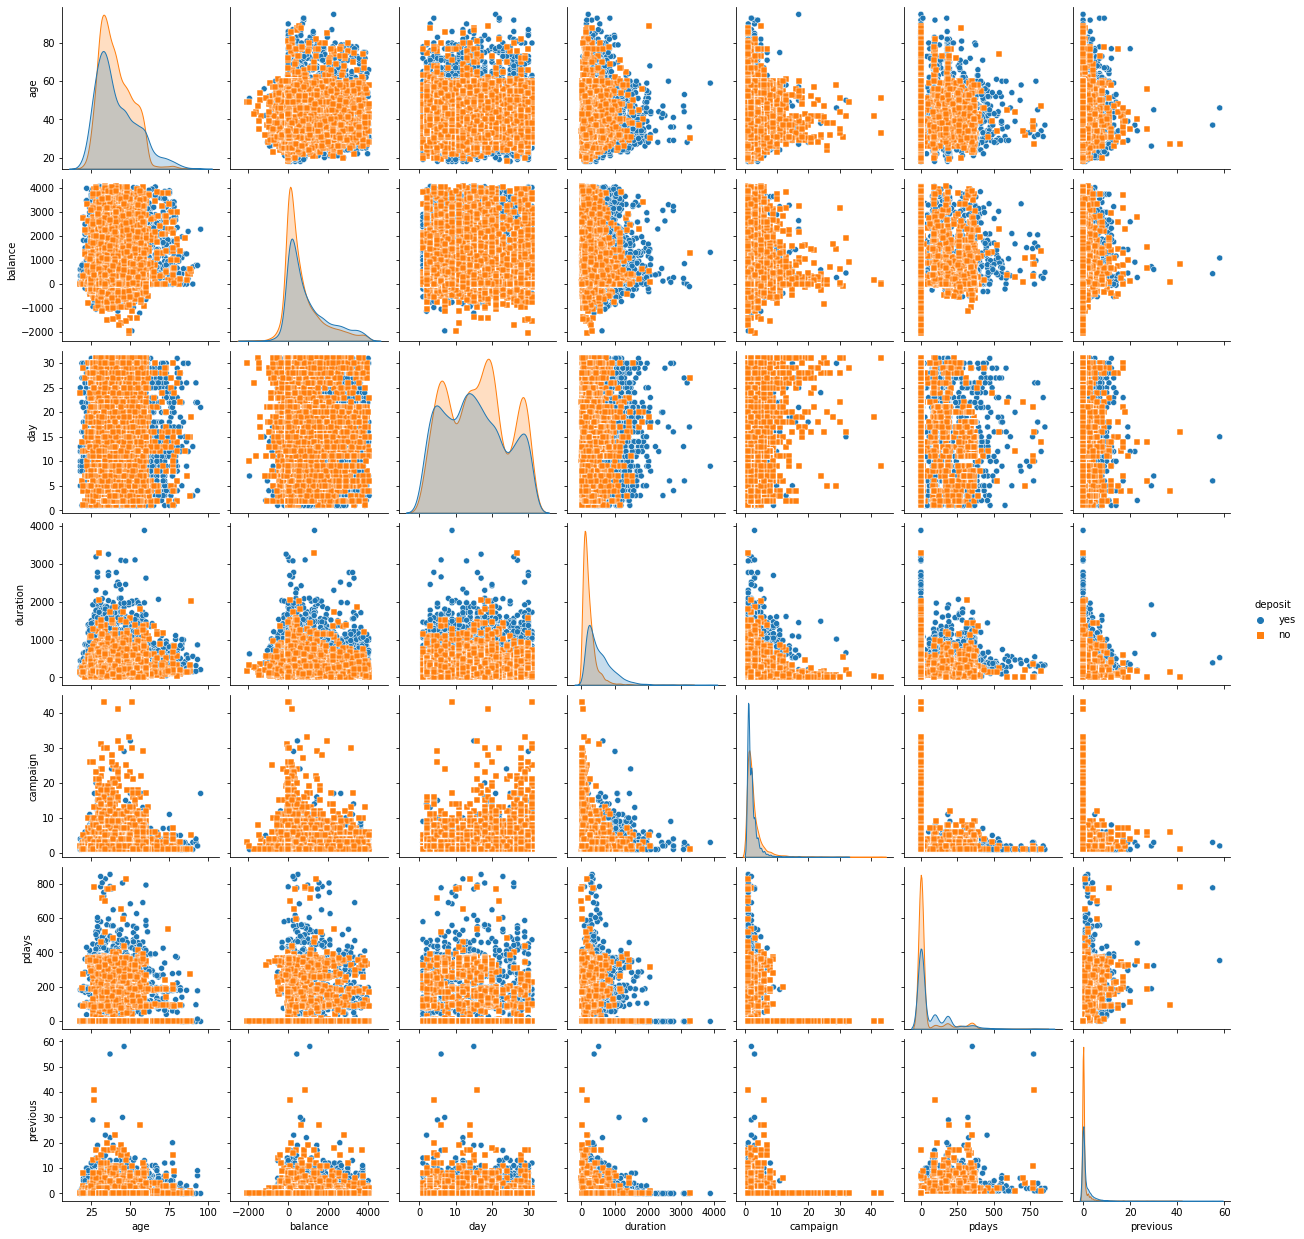

In [38]:
#Calculate descriptive statistics for quantitative variables

to_plot = (list(data_bank_fin_cleaned.describe().columns))
print(to_plot.append('deposit'))
plt.figure()
pairplot = sns.pairplot(data_bank_fin_cleaned[to_plot], hue='deposit', markers=["o", "s"])
plt.tick_params(axis='both', which='major', labelsize=20, rotation=90)
plt.show()

In [39]:
for column in data_bank_fin_cleaned.columns:
    if pd.DataFrame(data_bank_fin[column].value_counts()).shape[0] < 15:
        print(f'Feature {column}')
        display(pd.DataFrame(data_bank_fin[column].value_counts()))

Feature job


,job
management,2636
blue-collar,1944
technician,1823
admin.,1334
services,923
retired,778
self-employed,405
student,360
unemployed,357
entrepreneur,328


Feature marital


,marital
married,6351
single,3518
divorced,1293


Feature education


,education
secondary,5973
tertiary,3689
primary,1500


Feature default


,default
no,10994
yes,168


Feature housing


,housing
no,5881
yes,5281


Feature loan


,loan
no,9702
yes,1460


Feature contact


,contact
cellular,8042
unknown,2346
telephone,774


Feature month


,month
may,2824
aug,1519
jul,1514
jun,1222
nov,943
apr,923
feb,776
oct,392
jan,344
sep,319


Feature poutcome


,poutcome
unknown,8326
failure,1228
success,1071
other,537


Feature deposit


,deposit
no,5873
yes,5289


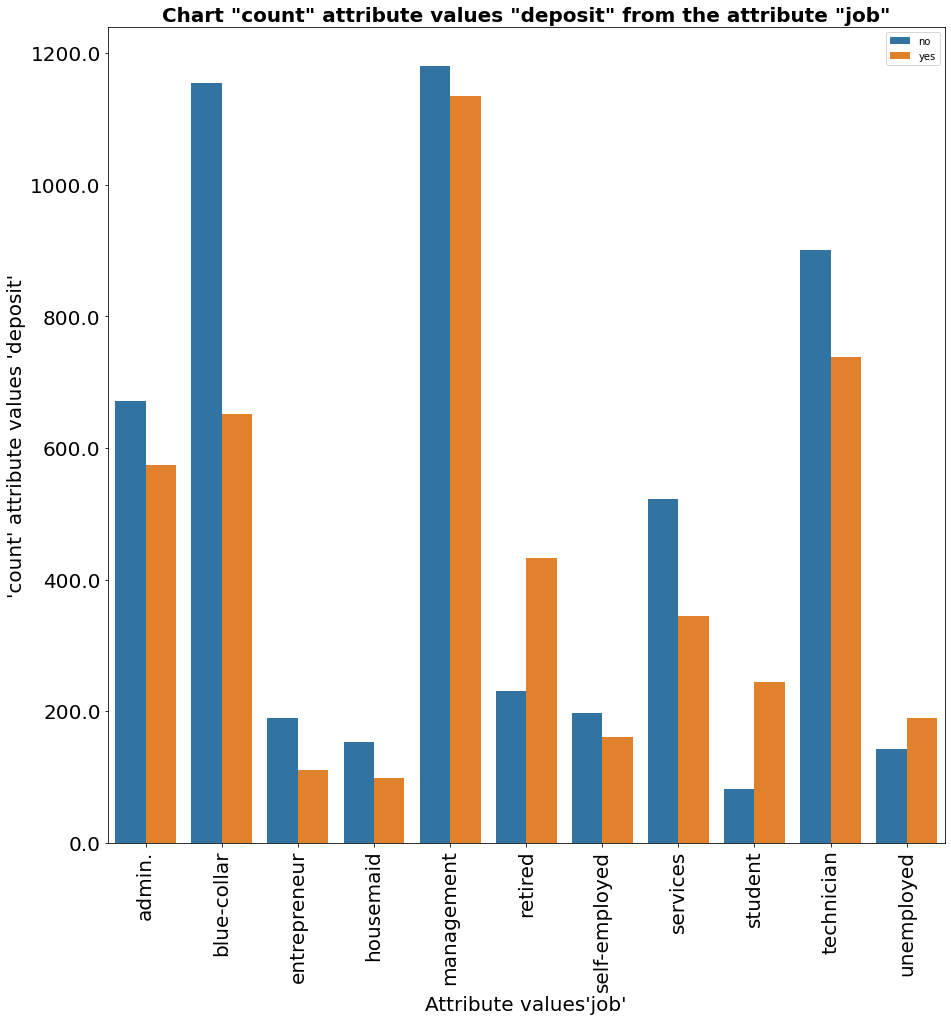

In [40]:
feature_x = 'job'
feature_y = 'deposit'
feature_hue = 'deposit'
agg_function = 'count'

# Let's create a function for rendering bar charts for various values of categorical data on the x axis, divided by the plot into 'yes' and 'no'

def barplot_creat(data_value, feature_x,feature_y,feature_hue, agg_function):
    data_group = data_value.groupby([feature_x,feature_hue],as_index=True)[[feature_y]].agg([agg_function]).reset_index()
    plt.figure(figsize=(15, 15))
    barplot = sns.barplot(
        data = data_group,
        x = data_group.values[:,0], 
        y = data_group.values[:,2],
        hue = data_group.values[:,1]
        )
    barplot.set_title(f'Chart "{agg_function}" attribute values "{feature_y}" from the attribute "{feature_x}"', fontweight='bold', fontsize=20)
    barplot.set_xlabel(f"Attribute values'{feature_x}'", size = 20)
    barplot.set_ylabel(f"'{agg_function}' attribute values '{feature_y}'", size = 20)
    barplot.set_yticklabels(barplot.get_yticks(), size = 20)
    plt.tick_params(axis='x', which='major', labelsize=20, rotation=90)

barplot_creat(data_bank_fin_cleaned, feature_x,feature_y, feature_hue, agg_function)

In [41]:
list_columns_to_barplot = []
for column in data_bank_fin_cleaned.columns:
    if pd.DataFrame(data_bank_fin_cleaned[column].value_counts()).shape[0] < 15 and column != 'deposit':
        list_columns_to_barplot.append(column)

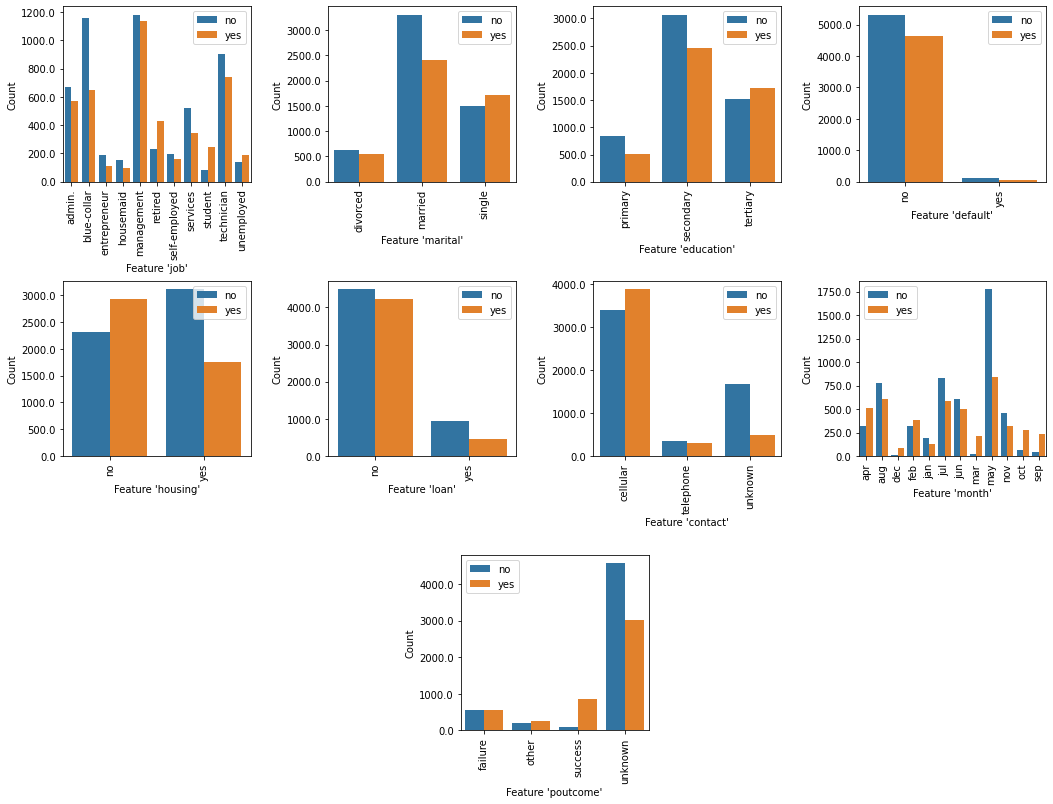

In [42]:
# Calculate descriptive statistics for categorical variables, interpret the results
# let's build visualizations illustrating the results
list_columns_to_barplot = []
for column in data_bank_fin_cleaned.columns:
    if pd.DataFrame(data_bank_fin_cleaned[column].value_counts()).shape[0] < 15 and column != 'deposit':
        list_columns_to_barplot.append(column)
import math
import matplotlib.gridspec as gridspec

feature_hue = 'deposit'
feature_y =  'deposit'
N_columns = len(list_columns_to_barplot)

n_columns_in_plot = 4
if N_columns % 2 == 1:
    n_rows_in_plot = math.ceil((N_columns + 1) / n_columns_in_plot)

k = -1

plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(18, 17)

for k in range(0,N_columns):
            
        column = list_columns_to_barplot[k]
                      
        data_group = data_bank_fin_cleaned.groupby([column,feature_hue],as_index=True)[[feature_y]].agg([agg_function]).reset_index()
        
        i = k // 4
        j = k % 4
        if k == N_columns - 1:
            
            axes = plt.subplot(gs[12:16, 6:9])
            
        else:
            axes = plt.subplot(gs[(i * 6):(i * 6 + 4), (j * 4):(j * 4 + 3)])
        axes = sns.barplot(ax=axes,
                    data = data_group,
                    x = data_group.values[:,0], 
                    y = data_group.values[:,2],
                    hue = data_group.values[:,1]
                             )
        
        axes.set_xlabel(f"Feature '{column}'", size = 10)
        axes.set_ylabel(f"Count", size = 10)
        axes.set_yticklabels(axes.get_yticks(), size = 10)
        axes.tick_params(axis='x', which='major', labelsize=10, rotation=90)

### Intermediate conclusions
1. Among the bank's clients, the largest number of clients working in administrative positions (admin.), "blue collar" (blue collar), managers (management) and technicians (technician)
2. There is more agreement ('yes') than 'no' among retired people, the unemployed and students. Apparently this is due to their fin. the state and lack of a stable income.
3. Most of the bank's clients are married, however, there is a large percentage of refusals. The singles category has the most agreement ('yes')
4. Among the bank's clients, the largest number has secondary education, the smallest - primary education. Those with higher education tend to have a positive target, the other two groups are the opposite situation
5. Very few customers with overdue loans
6. Do those who have a home loan have more rejections? than consents.
7. Clients without an education loan are still more likely to refuse, and then agree
8. Most of the contacts took place from a mobile phone
9. In May, there is a huge bias towards 'no', and in the months of April, December, February, September, October and March there are more 'yes', however, most contacts are in other months, and there are more 'no'

### Задание 6

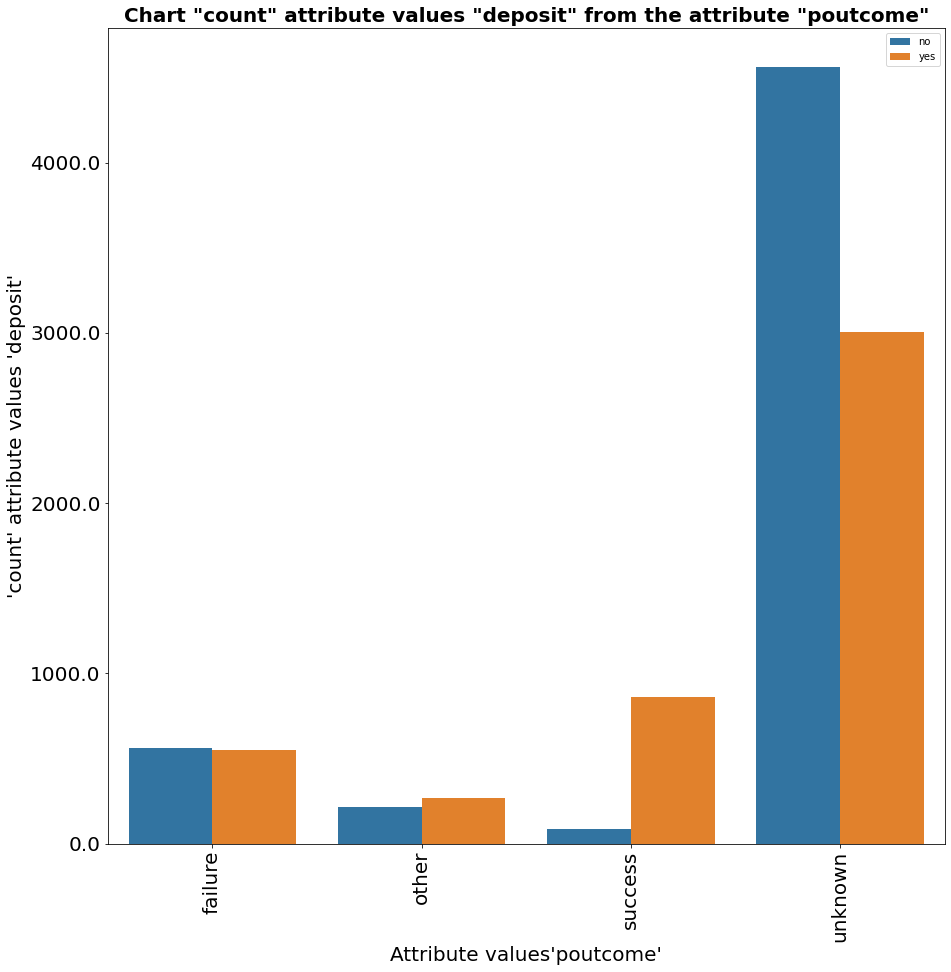

In [43]:
# Find out for which status of the previous marketing campaign success in the current one prevails over the number of failures.

feature_y = 'deposit'
feature_hue = 'deposit'
agg_function = 'count'
feature_x = 'poutcome'
barplot_creat(data_bank_fin_cleaned, feature_x, feature_y, feature_hue, agg_function)

### Intermediate conclusions
1. Among those who are 'yes' in the last company, the majority are 'yes' in the current company
2. But there is a lot of unknown, so it is difficult to speak confidently about it

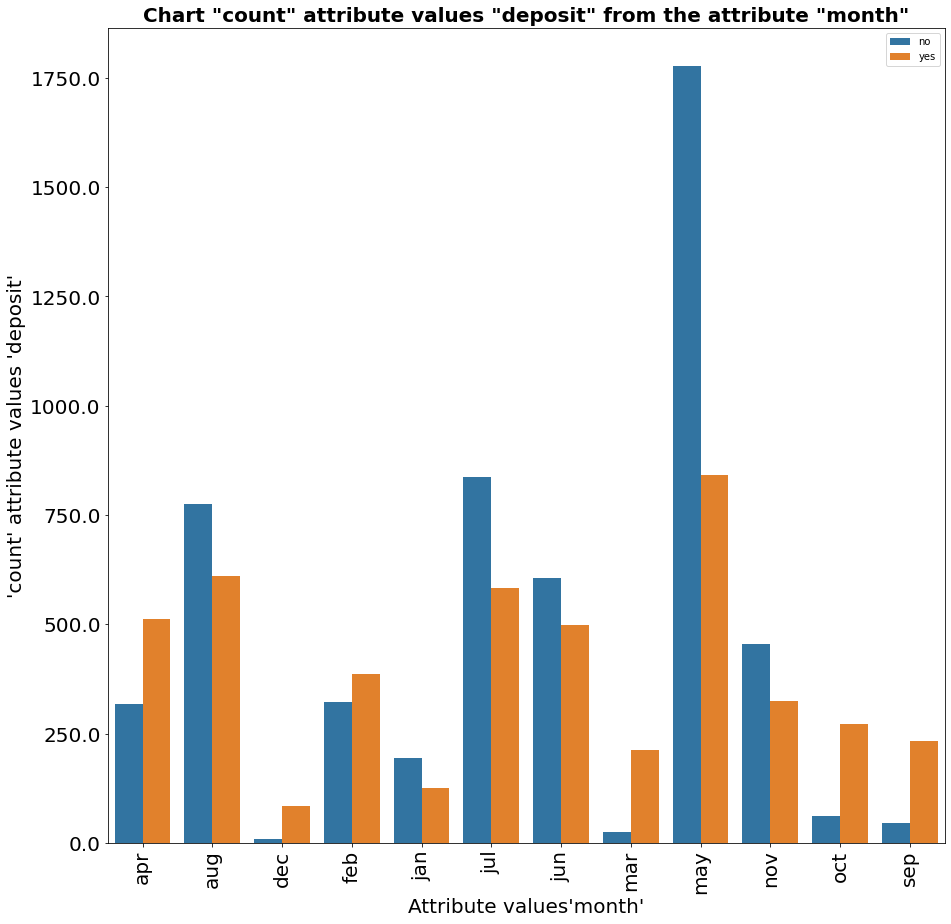

In [44]:
# Find out in which month the offer to open a deposit was most often refused
feature_y = 'deposit'
feature_hue = 'deposit'
agg_function = 'count'
feature_x = 'month'
barplot_creat(data_bank_fin_cleaned, feature_x, feature_y, feature_hue, agg_function)

### Intermediate conclusions
1. In May, there is a huge bias towards 'no', and in the months of April, December, February, September, October and March there are more 'yes', however, most contacts are in August, July, June, November and May, and there are more 'no'

### Задание 8

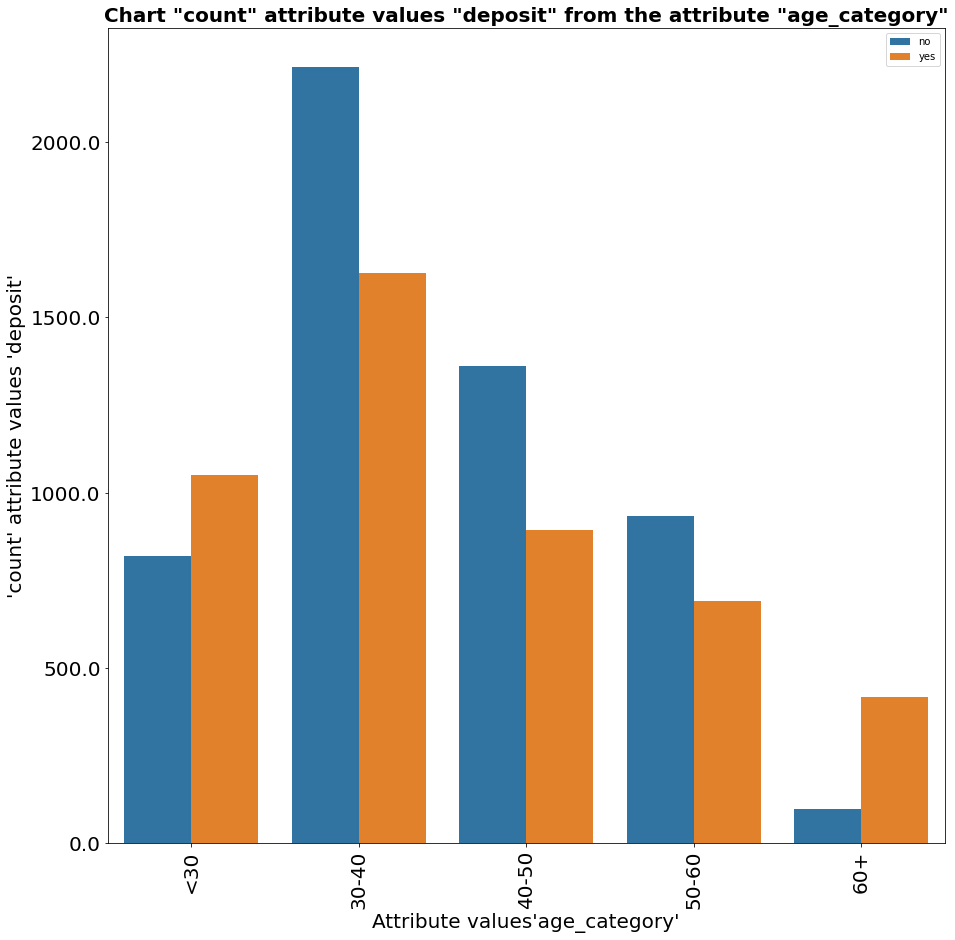

In [45]:
# Let's create age groups and determine which groups are more likely to open a deposit than to refuse an offer

data_bank_fin_cleaned['age_category'] = pd.cut(data_bank_fin_cleaned.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
feature_x = 'age_category'
feature_y = 'deposit'
feature_hue = 'deposit'
agg_function = 'count'
barplot_creat(data_bank_fin_cleaned, feature_x, feature_y, feature_hue, agg_function)

### Intermediate conclusions 
1. Very young ('<30') and elderly ('60+') tend to 'yes' more than 'no'

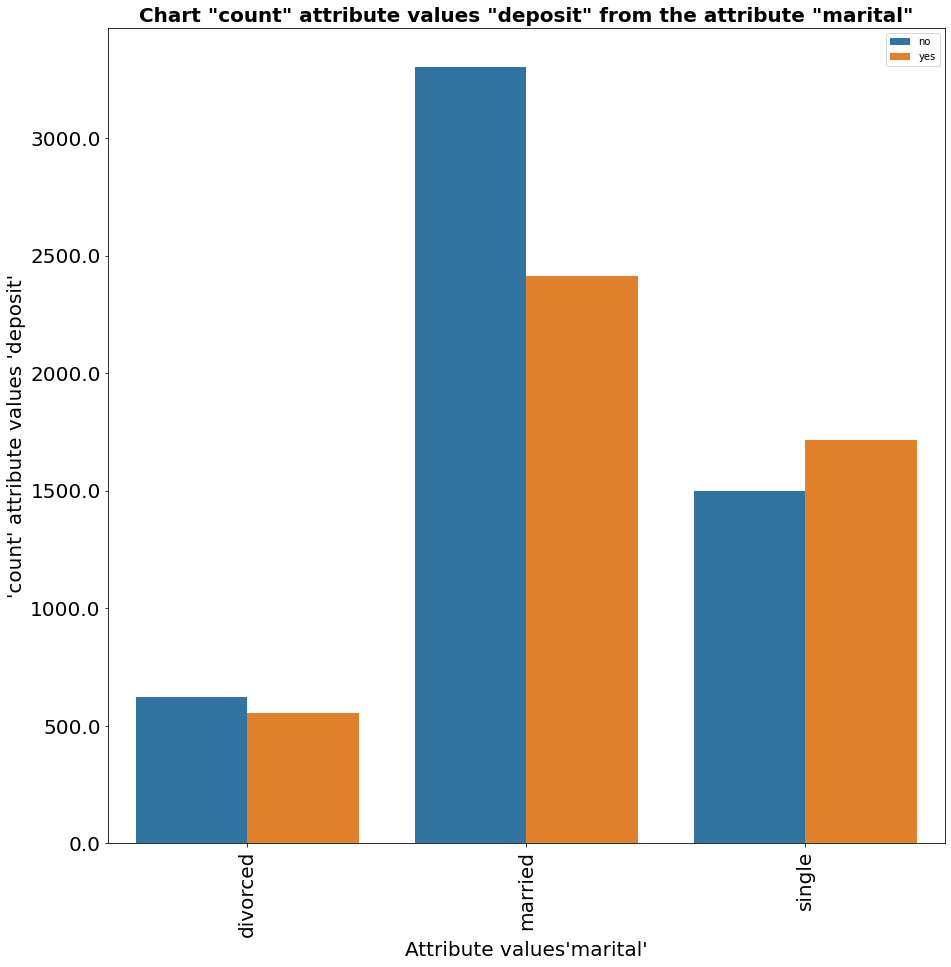

In [46]:
# We will build visualizations for those who have opened and not opened a deposit, depending on the family status
barplot_creat(data_bank_fin_cleaned, 'marital', feature_y, feature_hue, agg_function)

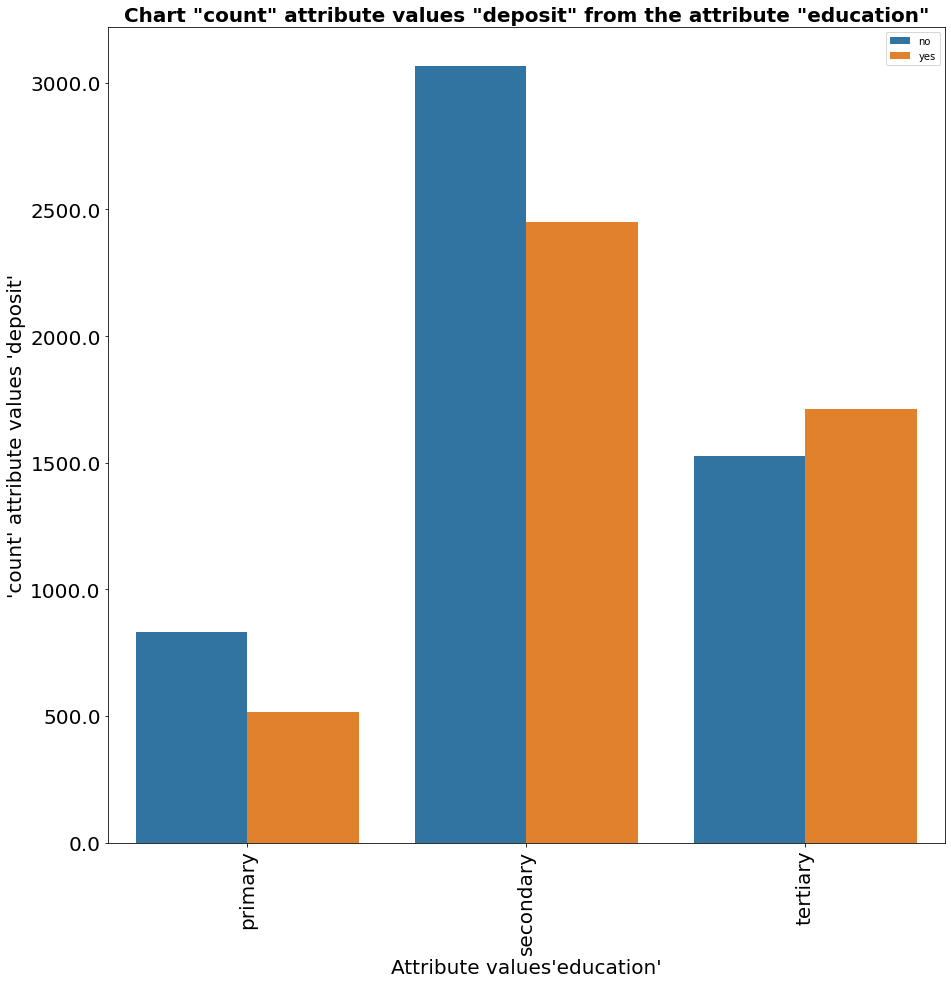

In [47]:
# Let's build visualizations for those who opened and those who did not open a deposit, depending on education
barplot_creat(data_bank_fin_cleaned, 'education', feature_y, feature_hue, agg_function)

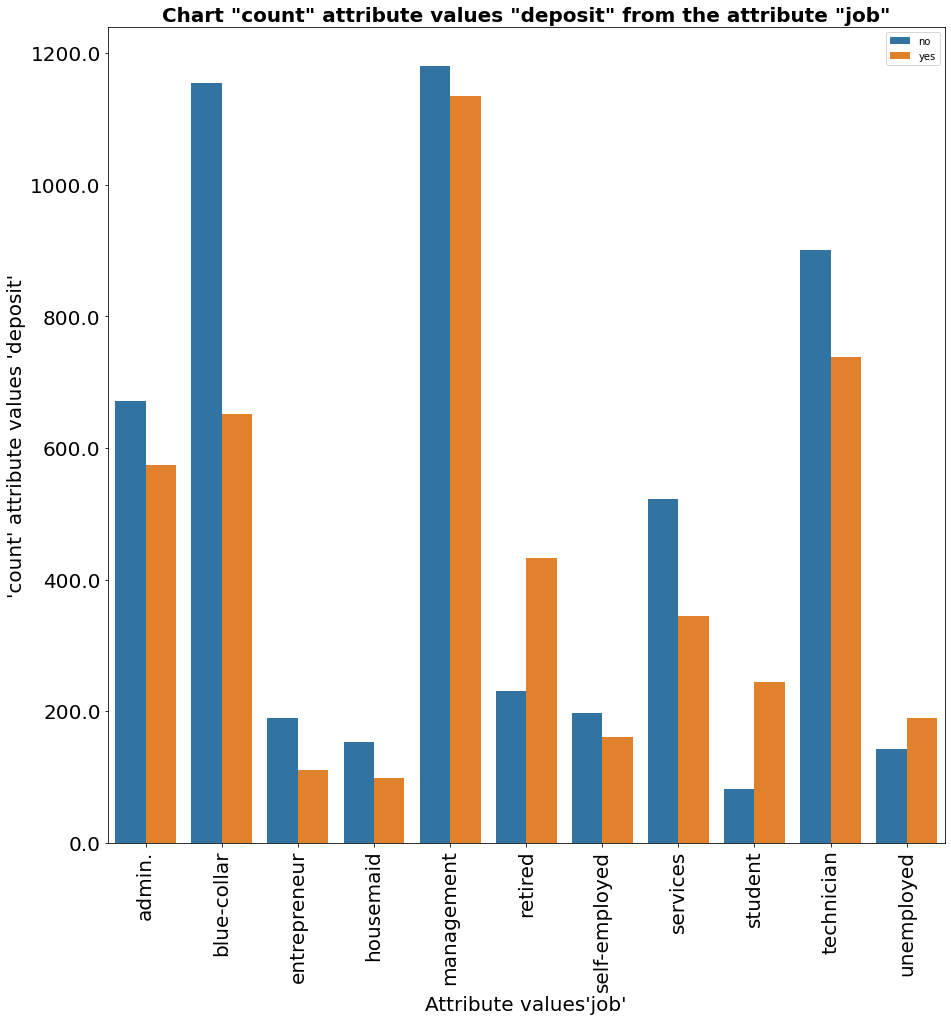

In [48]:
# We will build visualizations for those who have opened and not opened a deposit, depending on the type of professional employment
barplot_creat(data_bank_fin_cleaned, 'job', feature_y, feature_hue, agg_function)

### Задание 11

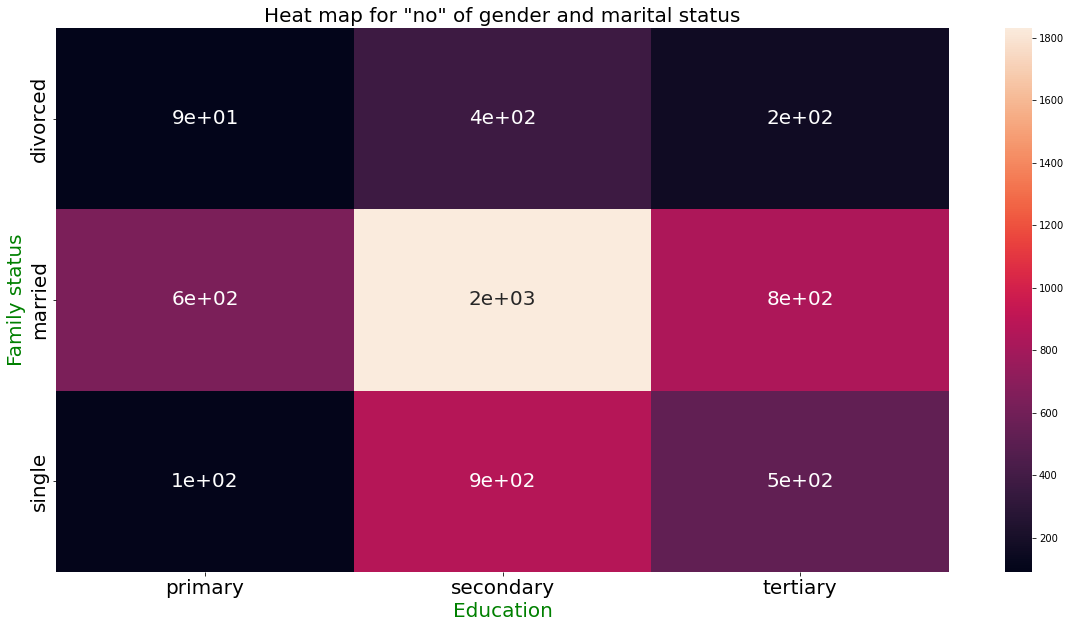

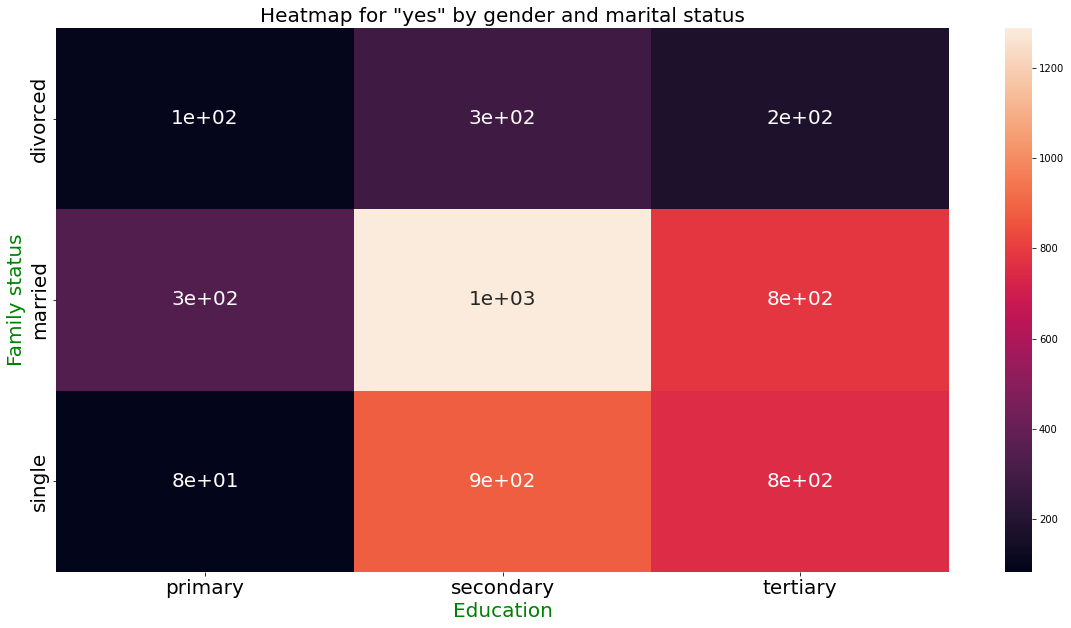

In [49]:
# Build a summary table to determine which people with education and family status are the most numerous
# (if we consider those who have opened a deposit)
from seaborn import colors


data_bank_fin_cleaned_isno = data_bank_fin_cleaned[data_bank_fin_cleaned['deposit'] == 'no']
data_bank_fin_cleaned_isyes = data_bank_fin_cleaned[data_bank_fin_cleaned['deposit'] == 'yes']

edu_mart_pivot_deposit_isno = pd.pivot_table(
        data_bank_fin_cleaned_isno, 
        values='deposit', 
        index='marital', 
        columns='education', 
        aggfunc='count', 
            )

plt.figure(figsize=(20,10))
heatmap = sns.heatmap(edu_mart_pivot_deposit_isno, annot = True, fmt='.1g',annot_kws={"size": 20})
heatmap.set_title('Heat map for "no" of gender and marital status', size = 20)
heatmap.set_xlabel(f"Education", size = 20, color = 'g')
heatmap.set_ylabel(f"Family status", size = 20, color = 'g')
heatmap.tick_params(axis='both', which='major', labelsize=20)

edu_mart_pivot_deposit_isyes = pd.pivot_table(
        data_bank_fin_cleaned_isyes, 
        values='deposit', 
        index='marital', 
        columns='education', 
        aggfunc='count', 
            )
plt.figure(figsize=(20,10))
heatmap = sns.heatmap(edu_mart_pivot_deposit_isyes, annot = True, fmt='.1g',annot_kws={"size": 20})
heatmap.set_title('Heatmap for "yes" by gender and marital status', size = 20)
heatmap.set_xlabel(f"Education", size = 20, color = 'g')
heatmap.set_ylabel(f"Family status", size = 20, color = 'g')
heatmap.tick_params(axis='both', which='major', labelsize=20)


## Part 3: Data transformation

In [50]:
# Transform education levels
label_encoder = LabelEncoder()
data_bank_fin_cleaned['education'] = label_encoder.fit_transform(data_bank_fin_cleaned['education'])
print('The sum for the processed values of the education attribute:',data_bank_fin_cleaned['education'].sum())

The sum for the processed values of the education attribute: 11995


In [51]:
data_bank_fin_cleaned['age_category'] = label_encoder.fit_transform(data_bank_fin_cleaned['age_category'])
display(data_bank_fin_cleaned['age_category'])

0        2
1        2
2        1
3        2
4        2
        ..
11157    0
11158    0
11159    0
11160    1
11161    0
Name: age_category, Length: 10105, dtype: int32

In [52]:
# convert binary variables into a representation of zeros and ones
data_bank_fin_cleaned['deposit'] = data_bank_fin_cleaned['deposit'].apply(lambda deposit: 1 if deposit == 'yes' else 0)
data_bank_fin_cleaned['deposit'].value_counts()

0    5424
1    4681
Name: deposit, dtype: int64

In [53]:
# We transform the remaining binary signs
data_bank_fin_cleaned['default'] = data_bank_fin_cleaned['default'].apply(lambda deposit: 1 if deposit == 'yes' else 0)
data_bank_fin_cleaned['housing'] = data_bank_fin_cleaned['housing'].apply(lambda deposit: 1 if deposit == 'yes' else 0)
data_bank_fin_cleaned['loan'] = data_bank_fin_cleaned['loan'].apply(lambda deposit: 1 if deposit == 'yes' else 0)

In [54]:
print('Sum for arithmetic averages feature values:',round(data_bank_fin_cleaned[['default','housing','loan']].mean().sum(),3))

Sum for arithmetic averages feature values: 0.635


In [55]:
# Create dummy variables

data_bank_fin_cleaned_dummies = pd.DataFrame(pd.get_dummies(data_bank_fin_cleaned[['job','marital','contact','month','poutcome']]))
data_bank_fin_cleaned_dummies_concat = pd.concat([data_bank_fin_cleaned,data_bank_fin_cleaned_dummies], axis = 1)

print('Total features in the dataset, not counting the target variable:',data_bank_fin_cleaned_dummies_concat.shape[1] - 1)

Total features in the dataset, not counting the target variable: 50


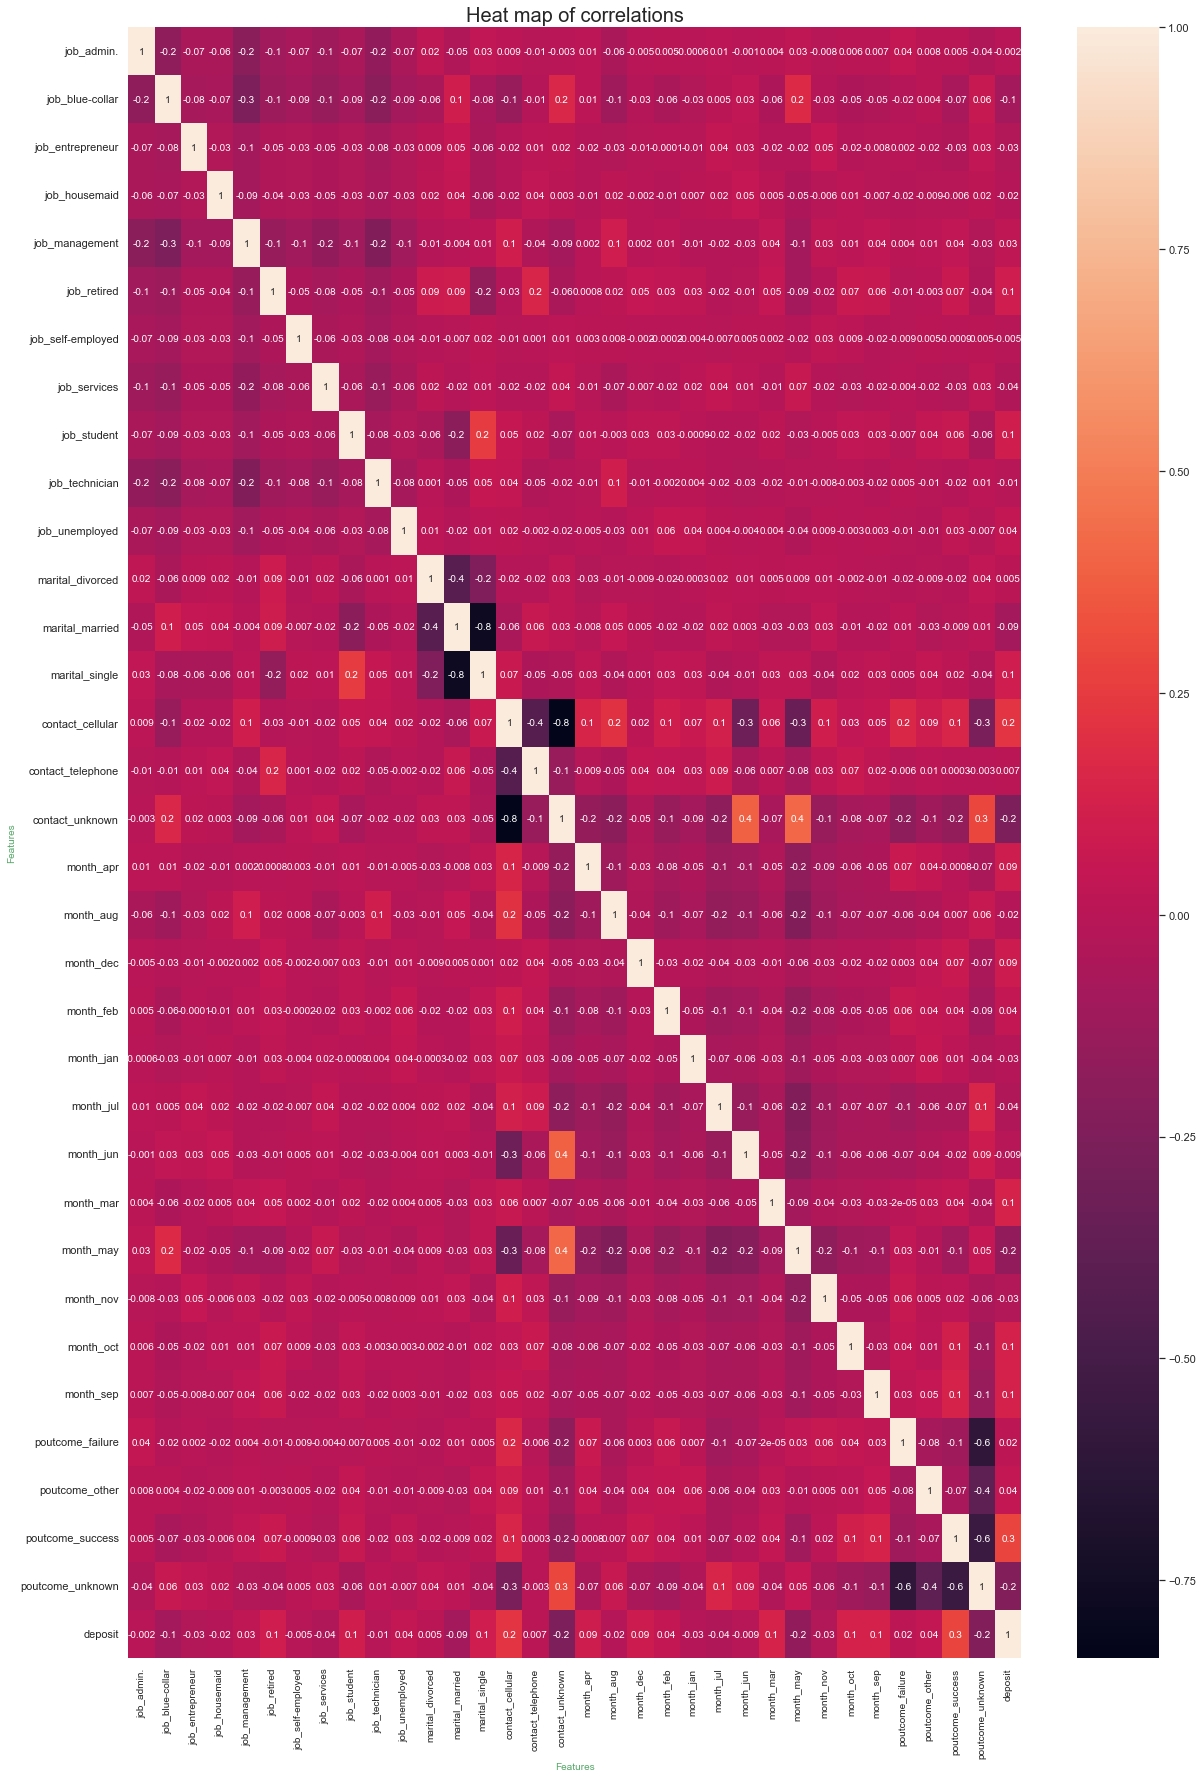

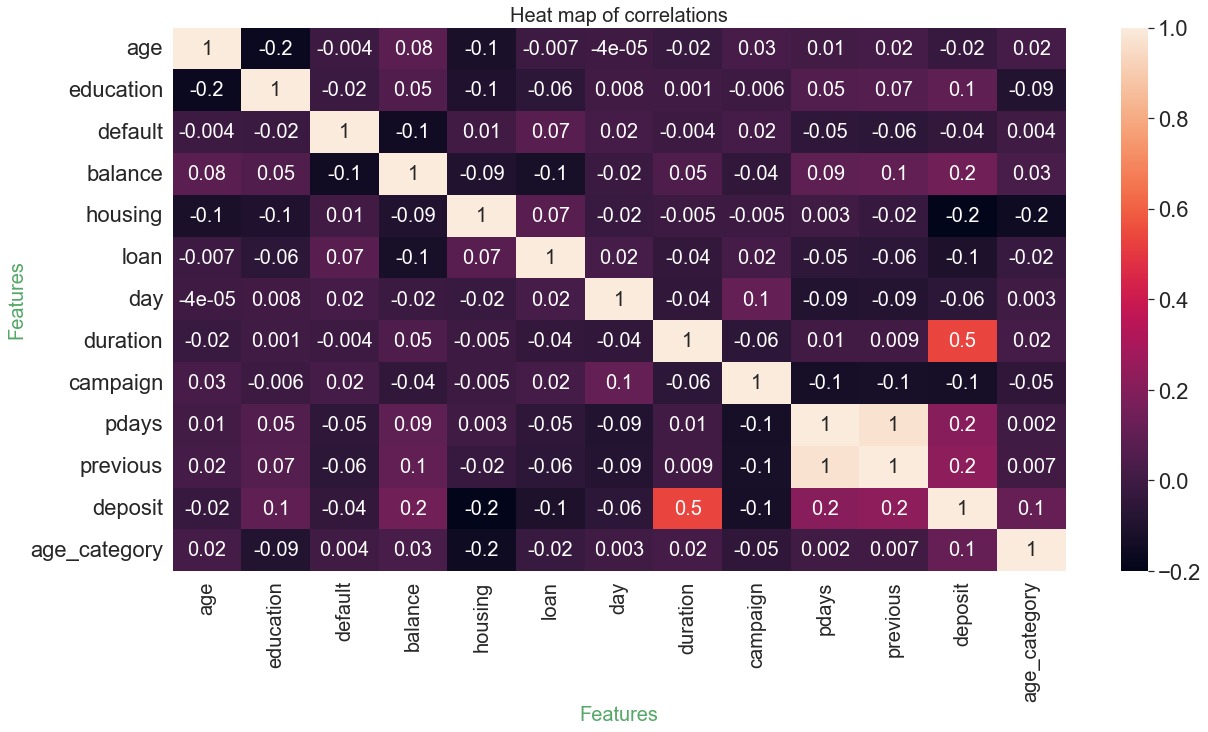

In [56]:
# let's build a correlation matrix and evaluate the data for the presence of multicollinearity

plt.figure(figsize=(20,30))
sns.set(font_scale=1)
heatmap = sns.heatmap(data_bank_fin_cleaned_dummies_concat[list(data_bank_fin_cleaned_dummies.columns) + ['deposit']].corr('spearman'), 
                      annot = True, fmt='.1g',annot_kws={"size": 10})
                      # annot = False)#, fmt='.1g',annot_kws={"size": 20})
heatmap.set_title('Heat map of correlations', size = 20)
heatmap.set_xlabel(f"Features", size = 10, color = 'g')
heatmap.set_ylabel(f"Features", size = 10, color = 'g')
heatmap.tick_params(axis='x', which='major', labelsize=10, rotation = 90)

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
heatmap = sns.heatmap(data_bank_fin_cleaned.corr('spearman'), annot = True, fmt='.1g',annot_kws={"size": 20})
heatmap.set_title('Heat map of correlations', size = 20)
heatmap.set_xlabel(f"Features", size = 20, color = 'g')
heatmap.set_ylabel(f"Features", size = 20, color = 'g')
heatmap.tick_params(axis='x', which='major', labelsize=20, rotation = 90)


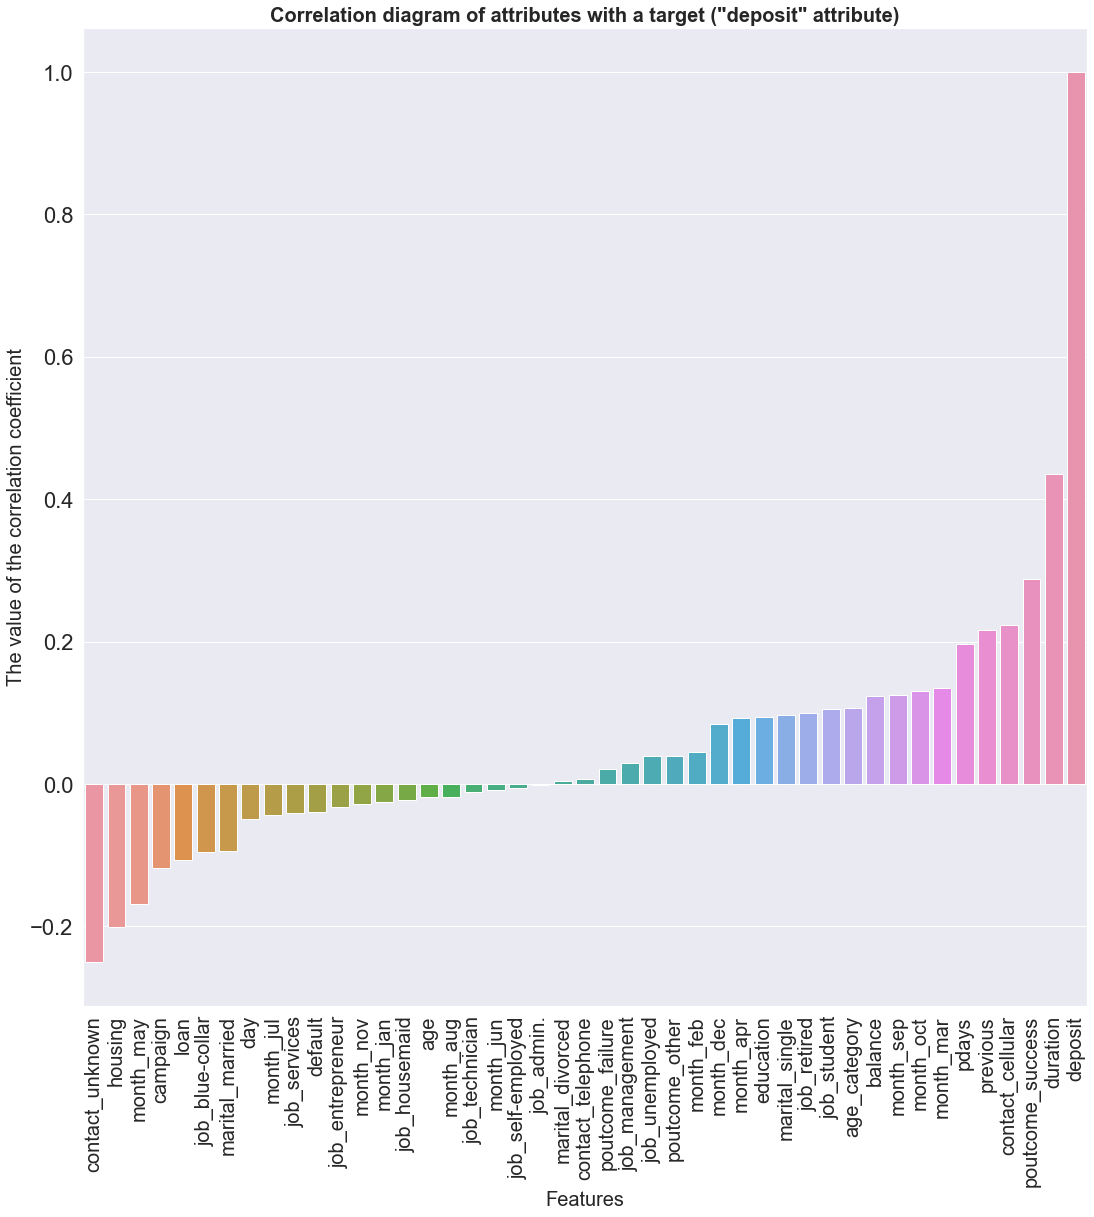

In [57]:
corr_target_matrix = pd.DataFrame(data_bank_fin_cleaned_dummies_concat.corr('kendall'))['deposit']

corr_target_matrix = corr_target_matrix.iloc[0:corr_target_matrix.shape[0]-1]
corr_target_matrix = pd.DataFrame(corr_target_matrix).sort_values(by='deposit' ,ascending=True)


plt.figure(figsize=(18, 18))

barplot = sns.barplot(
    data = corr_target_matrix,
    x = corr_target_matrix.index, 
    y = corr_target_matrix['deposit']
    )
barplot.set_title('Correlation diagram of attributes with a target ("deposit" attribute)', fontweight='bold', fontsize=20)
barplot.set_xlabel("Features", size = 20)
barplot.set_ylabel("The value of the correlation coefficient", size = 20)
barplot.tick_params(axis='x', which='major', labelsize=20, rotation = 90)
# The three most correlated features with the target are: 'duration','outcome_success', 'contact_cellular'


In [58]:
data_bank_fin_cleaned_dummies_concat_drop_cat_cols = data_bank_fin_cleaned_dummies_concat.drop(['job','marital','contact','month','poutcome'],axis=1)
data_bank_fin_cleaned_dummies_concat_drop_cat_cols

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,39,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,32,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,43,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


In [59]:
X = data_bank_fin_cleaned_dummies_concat_drop_cat_cols.drop(['deposit'], axis=1)
y = data_bank_fin_cleaned_dummies_concat_drop_cat_cols['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [60]:
# рассчитаем необходимые показатели
print('Test sample size:', y_test.shape[0])
print('The average value of the target variable in the test sample:',round(y_test.mean(),2))

Test sample size: 3335
The average value of the target variable in the test sample: 0.46


### Задание 9

In [61]:
# Using SelectKBest, we will select the 15 most suitable features

select = SelectKBest(score_func=f_classif, k=15)
z = select.fit_transform(X_train,y_train)
 
print("After selecting best 15 features:", z.shape) 
filter = select.get_support()
print(filter)
features = np.array(X_train.columns)
print(features[filter])
features_filter = features[filter]

X_train = X_train[features_filter]
X_test = X_test[features_filter]

After selecting best 15 features: (6770, 15)
[False False False  True  True False False  True  True  True  True  True
 False False False False False False False False False False False False
 False False  True False  True False False False False False False False
  True  True False  True  True False False  True  True]
['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous'
 'age_category' 'contact_cellular' 'contact_unknown' 'month_mar'
 'month_may' 'month_oct' 'month_sep' 'poutcome_success' 'poutcome_unknown']


In [62]:
data_bank_fin_cleaned_dummies_concat_drop_cat_cols_15_fetures = data_bank_fin_cleaned_dummies_concat_drop_cat_cols[features_filter]
print('Dataset size with 15 attributes:',data_bank_fin_cleaned_dummies_concat_drop_cat_cols_15_fetures.shape)

X = data_bank_fin_cleaned_dummies_concat_drop_cat_cols_15_fetures
y = data_bank_fin_cleaned_dummies_concat_drop_cat_cols['deposit']

# Let's create test and training samples
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

Dataset size with 15 attributes: (10105, 15)


### Задание 10

In [63]:
# Normalize the data using minmaxsxaler

from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features_filter)
X_test = pd.DataFrame(scaler.transform(X_test), columns=features_filter)

In [64]:
print('The average value of the predictor "balance" in the test sample:', round(X_test['balance'].mean(),2))

The average value of the predictor "balance" in the test sample: 0.47


# Part 4: Solving the classification problem: Logistic regression and decision trees

### Задание 1

In [65]:
# We will train logistic regression and calculate quality metrics
# Creating an object of the logistic regression class
log_reg_deposit = linear_model.LogisticRegression(random_state=42, solver='sag',max_iter=1000)
# Training the model by minimizing logloss
log_reg_deposit.fit(X_train, y_train)
y_pred_train = log_reg_deposit.predict(X_train)
y_pred_test = log_reg_deposit.predict(X_test)
# Calculating accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred_test)))

Accuracy: 0.82
Accuracy: 0.81


In [66]:
# Let's train the decision trees, set up the maximum depth

# Creating an object of the decision tree class
dtc_model = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
# Training the decision tree
dtc_model.fit(X_train, y_train)

# Output metric values
y_train_pred = dtc_model.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = dtc_model.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(metrics.classification_report(y_test, y_test_pred))

Train: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Test: 0.73
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



The maximum value of the accuracy metric 0.81


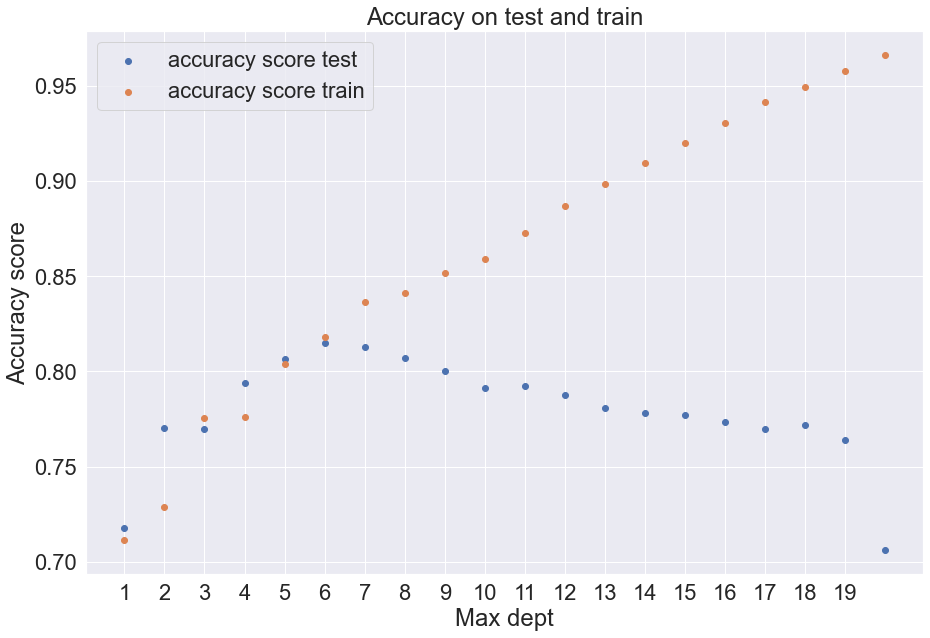

In [67]:
# Создаем объект класса дерево решений


def dtc_model_accuracy(max_dept):
    dtc_model = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=max_dept
    )
    # Training the decision tree
    dtc_model.fit(X_train, y_train)
    # Output metric values
    y_train_pred = dtc_model.predict(X_train)
    accuracy_score_train = metrics.accuracy_score(y_train, y_train_pred)
    
    y_test_pred = dtc_model.predict(X_test)
    accuracy_score_test = metrics.accuracy_score(y_test, y_test_pred)
    
    return accuracy_score_train, accuracy_score_test

fig, ax = plt.subplots(figsize=(15, 10)) # shape + coordinate plane

max_max_dept = 20
accuracy_score_train = np.zeros((max_max_dept,1))
accuracy_score_test = np.zeros((max_max_dept,1))
max_dept_plot = np.zeros((max_max_dept,1))
index = -1
for max_dept in range(1,max_max_dept+1):
    index += 1
    max_dept_plot[index,0] = max_dept
    accuracy_score_train[index,0], accuracy_score_test[index-1,0] = dtc_model_accuracy(max_dept)
    
ax.scatter(max_dept_plot, accuracy_score_test, label='accuracy score test')
ax.scatter(max_dept_plot, accuracy_score_train, label='accuracy score train')

ax.set_title('Accuracy on test and train')
ax.set_xlabel('Max dept')
ax.set_ylabel('Accuracy score')
ax.set_xticks(np.arange(1,max_max_dept))
ax.legend()
print('The maximum value of the accuracy metric',np.round(accuracy_score_test,2).max())

In [68]:
# # Let's select the optimal parameters using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10] , # minimum number of objects in a tree leaf
              'max_depth':[3,5,7], # maximum depth
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
                criterion='entropy',
                random_state=42,
                ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

grid_search.fit(X_train, y_train) 
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)
print('f1 score on the training set: {:.5f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1 score on the test set: {:.5f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Best hyperparameter values: {}".format(grid_search.best_params_))

f1 score on the training set: 0.82537
f1 score on the test set: 0.80279
Best hyperparameter values: {'max_depth': 7, 'min_samples_split': 10}


# Part 5: Solving the classification problem: ensembles of models and forecasting

In [69]:
# Let's train a random forest on our data
# Creating an object of the random forest class
rf_model = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
    )

# Training the model
rf_model.fit(X_train, y_train)
# Output metric values
y_train_pred = rf_model.predict(X_train)
print('Metrics on the training sample')
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = rf_model.predict(X_test)
print('Metrics on the test sample')
print(metrics.classification_report(y_test, y_test_pred))

# It can be seen that the model has signs of retraining, however, a good score was obtained on test

Metrics on the training sample
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Metrics on the test sample
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [70]:
# We use gradient boosting for classification and compare the quality with a random forest
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
gb_model.fit(X_train, y_train)
y_train_pred  = gb_model.predict(X_train)
y_test_pred  = gb_model.predict(X_test)

print('Metrics on the training sample')
print(metrics.classification_report(y_train, y_train_pred))
print('Metrics on a test sample')
print(metrics.classification_report(y_test, y_test_pred))

Metrics on the training sample
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

Metrics on a test sample
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [71]:
# Let's combine the algorithms already known to you with the help of stacking 
# Creating a list of tuples of the form: (model name, model)

from sklearn.ensemble import StackingClassifier

estimators = [
    ('lr_model', linear_model.LogisticRegression(
                                                random_state=42, 
                                                solver='sag',
                                                max_iter=1000
                                                )),
    ('tree_dtc_model', tree.DecisionTreeClassifier(
                                                   criterion='entropy',
                                                   random_state=42,
                                                   max_depth=7, 
                                                   min_samples_split=10
                                                   )),
    ('gbc_model', GradientBoostingClassifier(
                                            learning_rate = 0.05,
                                            n_estimators = 300,
                                            min_samples_leaf = 5,
                                            max_depth = 5,
                                            random_state = 42
                                            ))
            ]

#Создаем объект класса стекинг
stack_reg = StackingClassifier(
                                estimators=estimators,
                                final_estimator=linear_model.LogisticRegression(
                                                                                random_state=42, 
                                                                                solver='sag',
                                                                                max_iter=1000
                                                                                )
                                )
# Training the model
stack_reg.fit(X_train, y_train)

y_train_pred  = stack_reg.predict(X_train)
y_test_pred  = stack_reg.predict(X_test)

print('Metrics on the training sample')
print(metrics.classification_report(y_train, y_train_pred))
print('Metrics on the test sample')
print(metrics.classification_report(y_test, y_test_pred))

Metrics on the training sample
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3634
           1       0.86      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

Metrics on the test sample
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [72]:
# Let's evaluate which features demonstrate the greatest importance in the gradient boosting model

data_feature_importance = pd.DataFrame(data = {'feature': X.columns,'importance':gb_model.feature_importances_}).sort_values(by='importance',ascending=True)
display(data_feature_importance)

,feature,importance
14,poutcome_unknown,0.001408
7,contact_cellular,0.003620
5,previous,0.008449
12,month_sep,0.013530
3,campaign,0.014777
10,month_may,0.015214
11,month_oct,0.019880
9,month_mar,0.027819
6,age_category,0.039902
1,housing,0.047725


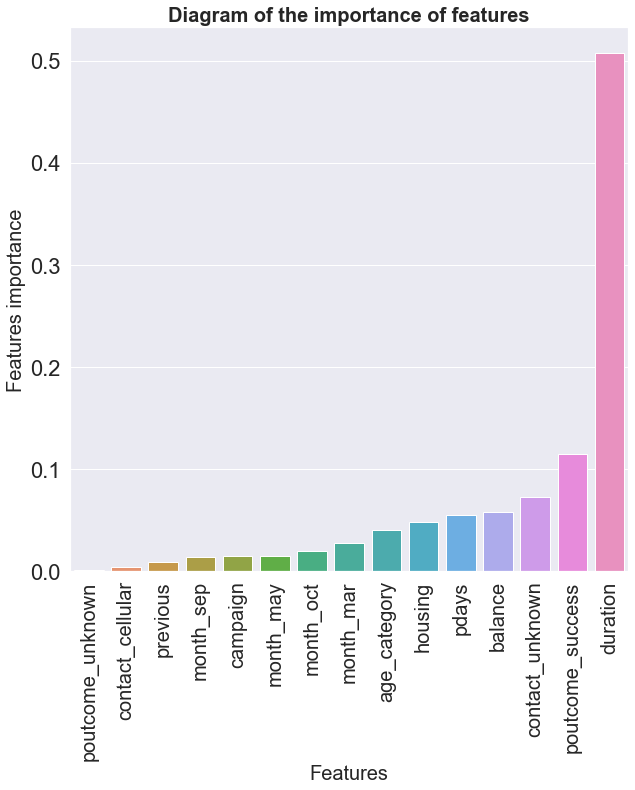

In [73]:
plt.figure(figsize=(10, 10))

barplot = sns.barplot(
    data = data_feature_importance,
    x = 'feature', 
    y = 'importance'
    )
barplot.set_title('Diagram of the importance of features', fontweight='bold', fontsize=20)
barplot.set_xlabel("Features", size = 20)
barplot.set_ylabel("Features importance", size = 20)
barplot.tick_params(axis='x', which='major', labelsize=20, rotation = 90)

### Intermediate conclusions 
1. The three main signs that affect the prediction are duration, outcome_success, contact_unknown
2. It is likely that the duration of contact affects the target by the fact that during the duration of communication, you can tell in detail about the advantages of opening a deposit and the interest in this on the part of the client is also important (he agrees to listen to these arguments)
3. Successful experience in the past has an impact on the target, the client trusts the bank more easily with a positive experience in the past
4. The unknown contact is probably still a direct contact in the bank's branches. Although in percentage terms it is less than phone contact, but it is the most effective.

In [74]:
import optuna
# Implementing hyperparameter optimization using Optuna
random_state = 42
def optuna_rf(trial):
    # defining hyperparameter search spaces
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # creating a model
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=random_state)
    # training the model
    model.fit(X_train, y_train)
    # Calculate metrics
    score_train = metrics.f1_score(y_train, model.predict(X_train))
    
    score_test = metrics.f1_score(y_test, model.predict(X_test))

    return score_test

In [75]:
# Сreating a research object
# Directly indicate that we need to maximize the metric direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# Дooking for the best combination of hyperparameters n_trials times
study.optimize(optuna_rf, n_trials=20)

[I 2022-10-19 19:30:46,675] A new study created in memory with name: RandomForestClassifier
[I 2022-10-19 19:30:47,846] Trial 0 finished with value: 0.8217884130982367 and parameters: {'n_estimators': 193, 'max_depth': 19, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8217884130982367.
[I 2022-10-19 19:30:48,773] Trial 1 finished with value: 0.8110687022900763 and parameters: {'n_estimators': 187, 'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8217884130982367.
[I 2022-10-19 19:30:49,662] Trial 2 finished with value: 0.8099173553719009 and parameters: {'n_estimators': 191, 'max_depth': 30, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8217884130982367.
[I 2022-10-19 19:30:50,160] Trial 3 finished with value: 0.8163136263041416 and parameters: {'n_estimators': 104, 'max_depth': 15, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8217884130982367.
[I 2022-10-19 19:30:50,818] Trial 4 finished with value: 0.816403785488959 and parameters: {'n

In [76]:
# выводим результаты на обучающей выборке
print("Best hyperparameter values {}".format(study.best_params))
print("f1 score on the test set: {:.2f}".format(study.best_value))

Best hyperparameter values {'n_estimators': 199, 'max_depth': 15, 'min_samples_leaf': 5}
f1 score on the test set: 0.82


In [77]:
# Сalculate the accuracy of the model for the test sample
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("Accuracy on the test set: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1 score on the test set: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


print("Accuracy on the train set: {:.2f}".format(model.score(X_train, y_train)))
print('f1 score on train set: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

Accuracy on the test set: 0.83
f1 score on the test set: 0.82
Accuracy on the train set: 0.87
f1 score on train set: 0.86


### Глобальные выводы
1. Проведены этапы построения модели классификации клиентов реального банка на тех, кто откроет депозит, и тех, кто не откроет
2. Проведена первичная обработка данных, в рамках которой были обработаны пропуски и выбросы. 
3. Проведен Разведывательный анализ данных (EDA). В результате обнаружены первые закономерности и выдвинуты гипотезы о зависимостях в данных
4. Произведен отбор и преобразование признаков. Были перекодированы и преобразованы данные, чтобы их можно было использовать при решении задачи классификации.
5. Была решена задача классификации методами логистической регрессия и решающих деревьев 
6. Была решена задача классификации с применением ансамблей моделей (градиентный бустинг и стекинг) с поиском оптимальных параметров при помощи optuna и grid search.